# Reproducing idealised exoplanet simulations
## Source: Mayne et al. (2014)

### Synopsis

This notebook goes through the following steps:
1. Load the UM output using `iris`, thus representing each of the output variables as `iris.cube.Cube`.
2. Interpolate `iris` cubes from the levels of constant height to the levels of constant air pressure using the `python-stratify` library (via `aeolus`).
3. Average the data over time and/or longitude using functions from `aeolus`.
4. Plot the results and save them to the `../plots/` directory.
   * Using the "old" style of the original paper
   * Using modern `matplotlib` style

### Import the necessary libraries

Standard library

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from functools import partial

Scientific stack

In [3]:
import iris
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

In [4]:
from tqdm.notebook import tqdm

aeolus

In [5]:
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import (
    get_cube_rel_days,
    get_xy_coords,
    interp_cube_from_height_to_pressure_levels,
    interp_cubelist_from_height_to_pressure_levels,
    regrid_3d,
)
from aeolus.model import um
from aeolus.subset import extract_last_n_days

local scripts

In [6]:
import mypaths
from plot_func import cube_stats_string, figsave, use_style

### Some global definitions

Apply a custom `matplotlib` style.

In [7]:
use_style()

Create a path effects object to highlight contours for later

In [8]:
PE = [PathEffects.withStroke(linewidth=0.5, foreground="w")]

Select the run configuration

In [9]:
planet = "earth"
SIM_LABEL = "Held-Suarez test"
const = init_const(planet)

Common directory where to save plots.

In [10]:
plot_dir = mypaths.plotdir / "mayne2014_gmd_plots"

### Load the data into a cube list

Use `sadir` from the `mypaths` script to find the data. Adapt the file path to the one on your machine in the `mypaths.py` script.

In [11]:
%%time
cl = iris.load(str(mypaths.sadir / "held_suarez" / "atmosa.p*"))

CPU times: user 1min 49s, sys: 2.41 s, total: 1min 51s
Wall time: 1min 52s


### Interpolate and clean the data

In [12]:
selected_cubes = cl.extract_cubes([um.pres, um.temp, um.u, um.v])

Select days 200-1200.

In [13]:
selected_cubes = iris.cube.CubeList(
    [extract_last_n_days(i, 1000) for i in selected_cubes]
)

Add planet configuration to the cubes.

In [14]:
add_planet_conf_to_cubes(selected_cubes, const)

#### Interpolate selected data to a common height-latitude-longitude grid

In [15]:
target_cube = selected_cubes.extract_cube(um.pres)

In [16]:
height_lev_cubes = iris.cube.CubeList()
height_lev_cubes.append(target_cube)
for cube in tqdm(selected_cubes[1:]):
    height_lev_cubes.append(regrid_3d(cube, target_cube, model=um))

  0%|          | 0/3 [00:00<?, ?it/s]

#### Interpolate selected data to sigma-pressure levels

Create a callable to pass to the interpolation routine. Use linear extrapolation.

In [17]:
INTERPOLATOR = partial(
    stratify.stratify.interpolate,
    interpolation=stratify.stratify.INTERPOLATE_LINEAR,
    extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
)

Create an array of sigma levels, using the table A1 in Mayne et al. (2014).

In [18]:
sigma_levels = np.array(
    [
        1.0,
        0.97,
        0.94,
        0.91,
        0.88,
        0.84,
        0.81,
        0.78,
        0.75,
        0.72,
        0.69,
        0.66,
        0.63,
        0.6,
        0.57,
        0.53,
        0.5,
        0.47,
        0.44,
        0.41,
        0.38,
        0.35,
        0.32,
        0.28,
        0.26,
        0.22,
        0.19,
        0.16,
        0.13,
        0.1,
        0.07,
        0.04,
        0.01,
    ]
)

#### Test the interpolation using the cube of height

In [19]:
cube_of_height = cl.extract("height_above_reference_ellipsoid")[0]

In [20]:
cube_of_height_plev = interp_cube_from_height_to_pressure_levels(
    cube_of_height,
    target_cube[0, ...],
    sigma_levels,
    p_ref_frac=True,
    interpolator=INTERPOLATOR,
)

Text(0.5, 1.0, '(test) p=100000.0 Pa')

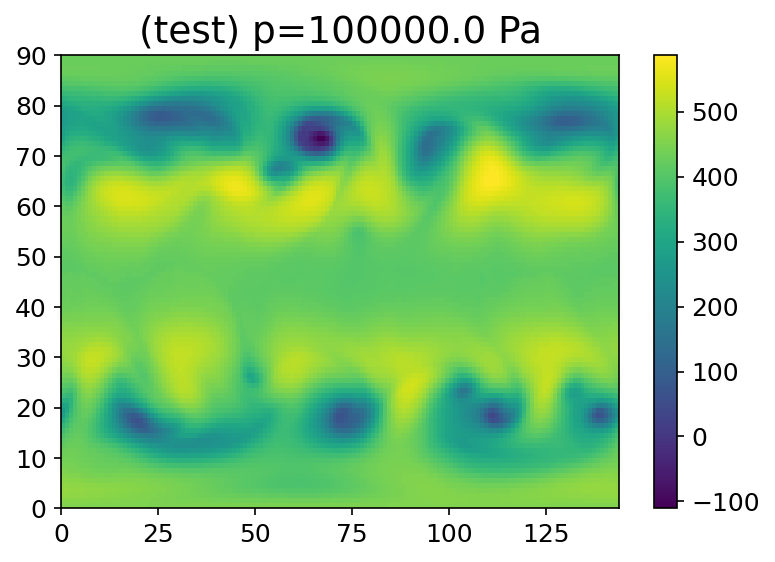

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
p0 = ax.pcolormesh(cube_of_height_plev[0, ...].data)
fig.colorbar(p0)
ax.set_title(f"(test) p={cube_of_height_plev[0, ...].coord(um.pres).points[0]} Pa")

In [22]:
cube_of_height_plev_gm = spatial_mean(cube_of_height_plev, model=um)
normalised_height = cube_of_height_plev_gm.data / 30975.0

Compare with Table A1 in the paper.

In [23]:
[*zip(sigma_levels, np.round(normalised_height, decimals=6))]

[(1.0, 0.013428),
 (0.97, 0.021748),
 (0.94, 0.03008),
 (0.91, 0.039068),
 (0.88, 0.048286),
 (0.84, 0.060597),
 (0.81, 0.0704),
 (0.78, 0.080538),
 (0.75, 0.090725),
 (0.72, 0.101414),
 (0.69, 0.112508),
 (0.66, 0.123736),
 (0.63, 0.135639),
 (0.6, 0.14788),
 (0.57, 0.16053),
 (0.53, 0.178322),
 (0.5, 0.192293),
 (0.47, 0.206977),
 (0.44, 0.22228),
 (0.41, 0.238543),
 (0.38, 0.255595),
 (0.35, 0.273765),
 (0.32, 0.293233),
 (0.28, 0.321336),
 (0.26, 0.336627),
 (0.22, 0.370234),
 (0.19, 0.399054),
 (0.16, 0.432099),
 (0.13, 0.471368),
 (0.1, 0.521215),
 (0.07, 0.588781),
 (0.04, 0.695052),
 (0.01, 0.959047)]

#### Interpolate the main data

In [24]:
%%time
pres_lev_cubes = interp_cubelist_from_height_to_pressure_levels(
    height_lev_cubes,
    sigma_levels,
    p_ref_frac=True,
    include_pressure=True,
    interpolator=INTERPOLATOR,
)

CPU times: user 24.9 s, sys: 9.87 s, total: 34.7 s
Wall time: 30.2 s


In [25]:
pres_lev_cubes

[<iris 'Cube' of air_pressure / (Pa) (time: 100; air_pressure: 33; latitude: 90; longitude: 144)>,
<iris 'Cube' of air_temperature / (K) (time: 100; air_pressure: 33; latitude: 90; longitude: 144)>,
<iris 'Cube' of x_wind / (m s-1) (time: 100; air_pressure: 33; latitude: 90; longitude: 144)>,
<iris 'Cube' of y_wind / (m s-1) (time: 100; air_pressure: 33; latitude: 90; longitude: 144)>]

In [26]:
airtemp = pres_lev_cubes.extract_cube(um.temp)

Get latitude and longitude points (they are the same for all variables in this dataset).

In [27]:
lons, lats = get_xy_coords(airtemp, model=um)

In [28]:
lons, lats = lons.points, lats.points

### Plot the results

**Figure 2.** Time and zonal mean of air temperature on sigma levels.

In [29]:
airtemp_tzm = time_mean(zonal_mean(airtemp))

##### An old-school version for direct comparison with the paper

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__time_zonal_mean.png.png


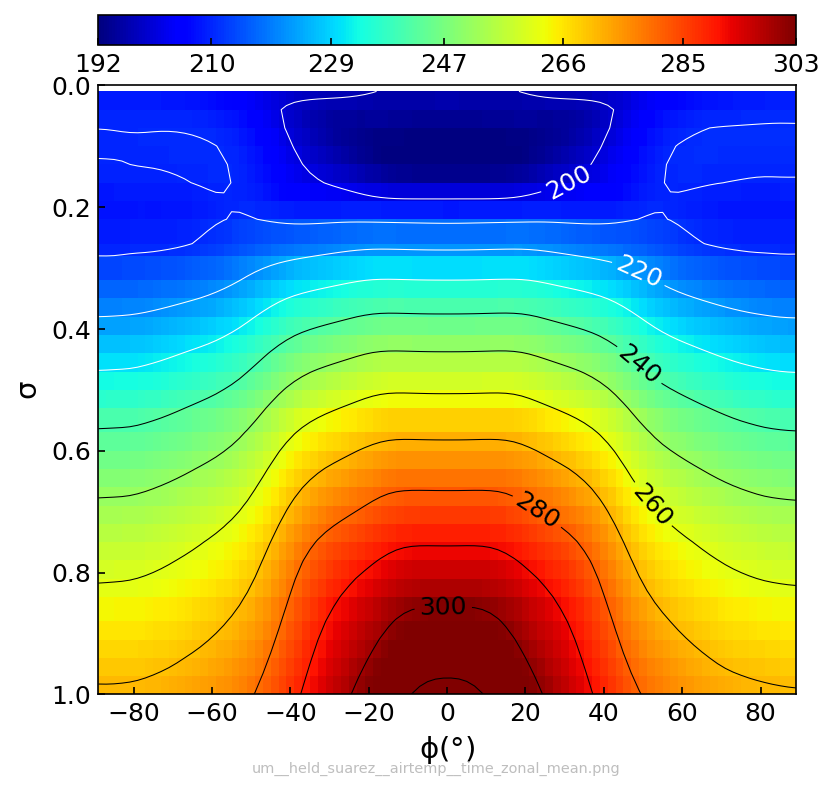

In [30]:
fig, (cax, ax) = plt.subplots(
    nrows=2,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [0.05, 1], "hspace": 0.125},
)

p0 = ax.pcolormesh(lats, sigma_levels, airtemp_tzm.data, cmap="jet", vmin=192, vmax=303)
p1 = ax.contour(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(240, 400, 10),
)
c1 = ax.clabel(p1, levels=np.arange(240, 400, 20), fmt="%.0f", use_clabeltext=True)
p2 = ax.contour(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    colors="w",
    linewidths=0.5,
    levels=np.arange(100, 240, 10),
)
c2 = ax.clabel(p2, levels=np.arange(100, 240, 20), fmt="%.0f", use_clabeltext=True)
ax.set_ylim([1, 0])
ax.tick_params(direction="in")
ax.set_xticks(np.arange(-80, 81, 20))

cb = fig.colorbar(p0, orientation="horizontal", cax=cax)
cb.ax.tick_params(direction="in")
cb.set_ticks([192, 210, 229, 247, 266, 285, 303])

ax.set_xlabel("$\phi$($\degree$)")
ax.set_ylabel("$\sigma$")

imgname = plot_dir / "um__held_suarez__airtemp__time_zonal_mean.png"
figsave(fig, imgname)

Note that figsave takes optional arguments. You can also change `matplotlib`'s defaults in the `simple.mplstyle` style sheet or using `plt.rcParams` in the notebook itself.

##### A better and simpler version

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__time_zonal_mean__new.png.png


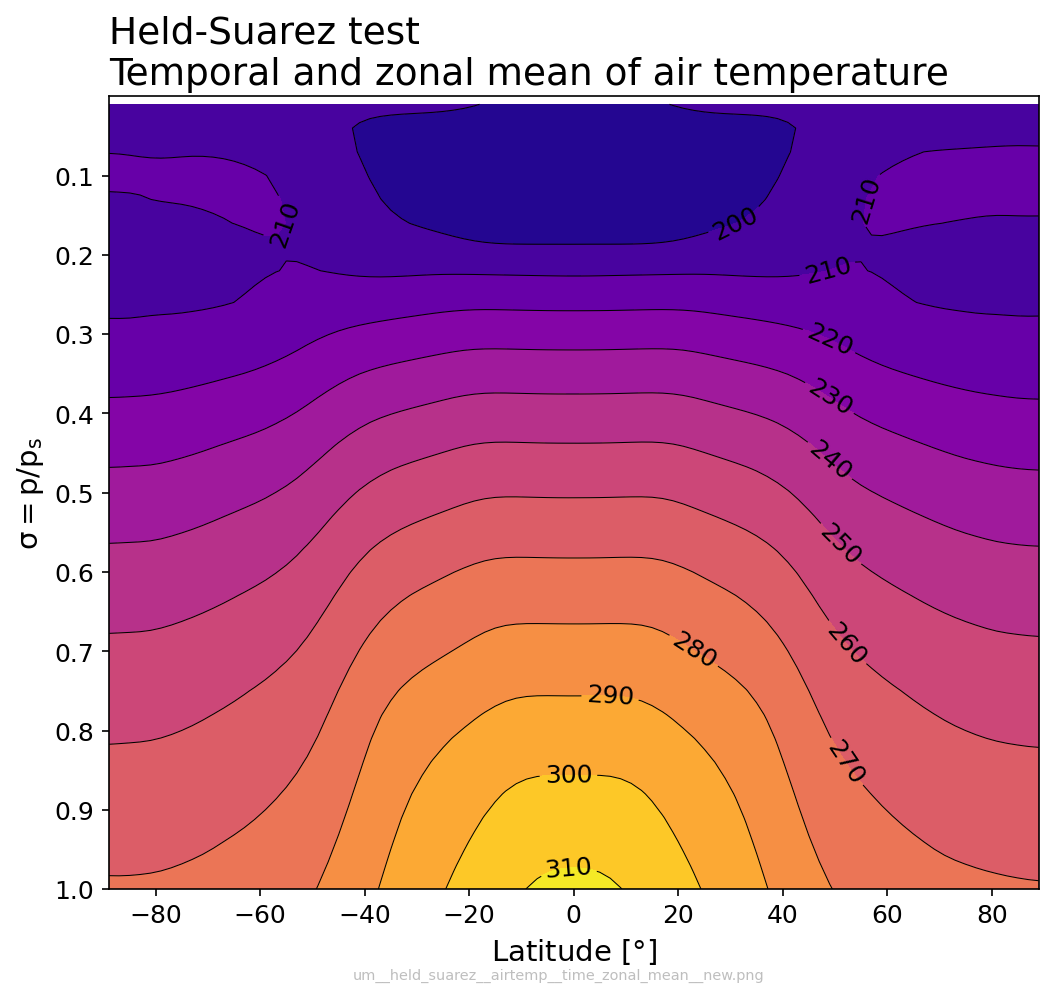

In [31]:
fig, ax = plt.subplots(figsize=(8, 7))

p0 = ax.contourf(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    cmap="plasma",
    levels=np.arange(190, 321, 10),
)
p1 = ax.contour(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(200, 400, 10),
)
c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)

ax.set_xticks(np.arange(-80, 81, 20))
ax.set_yticks(np.arange(1.0, 0.0, -0.1))
ax.set_ylim([1, 0])

ax.set_xlabel("Latitude [$\degree$]")
ax.set_ylabel("$\sigma=p/p_s$")
ax.set_title("Held-Suarez test\nTemporal and zonal mean of air temperature", loc="left")

imgname = plot_dir / "um__held_suarez__airtemp__time_zonal_mean__new.png"
figsave(fig, imgname)

**Figure 3.** Time and zonal mean of zonal wind on sigma levels.

In [32]:
u_tzm = time_mean(zonal_mean(pres_lev_cubes.extract_cube(um.u)))

##### An old-school version for direct comparison with the paper

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__u__Time_zonal_mean.png.png


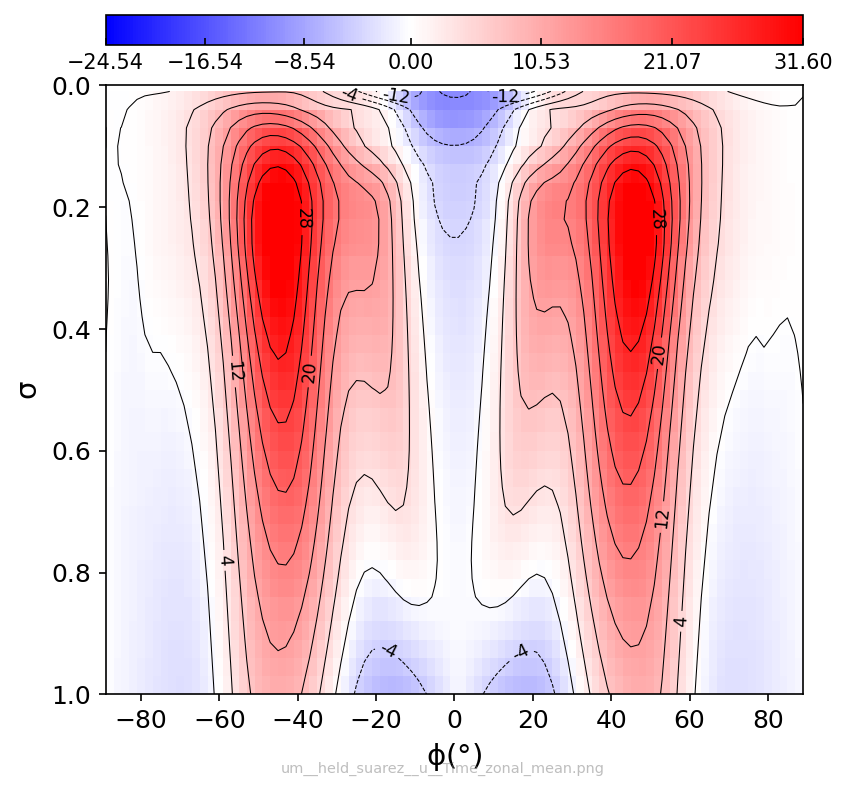

In [33]:
fig, (cax, ax) = plt.subplots(
    nrows=2,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [0.05, 1], "hspace": 0.125},
)

p0 = ax.pcolormesh(
    lats,
    sigma_levels,
    u_tzm.data,
    cmap="bwr",
    norm=mcol.TwoSlopeNorm(vcenter=0, vmin=-24.54, vmax=31.60),
)
p1 = ax.contour(
    lats,
    sigma_levels,
    u_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(-28, 29, 4),
)
c1 = ax.clabel(
    p1,
    levels=np.arange(-28, 29, 8),
    fmt="%.0f",
    fontsize="x-small",
    use_clabeltext=True,
)

cb = fig.colorbar(p0, orientation="horizontal", cax=cax)
cb.ax.tick_params(direction="in", labelsize="small")
cb.set_ticks([-24.54, -16.54, -8.54, 0.00, 10.53, 21.07, 31.60])
# cb.ax.set_xlim([-24.54, 31.60])

ax.set_ylim([1, 0])
ax.set_xlabel("$\phi$($\degree$)")
ax.set_ylabel("$\sigma$")

imgname = plot_dir / "um__held_suarez__u__Time_zonal_mean.png"
figsave(fig, imgname)

##### A better and simpler version

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__u__time_zonal_mean__new.png.png


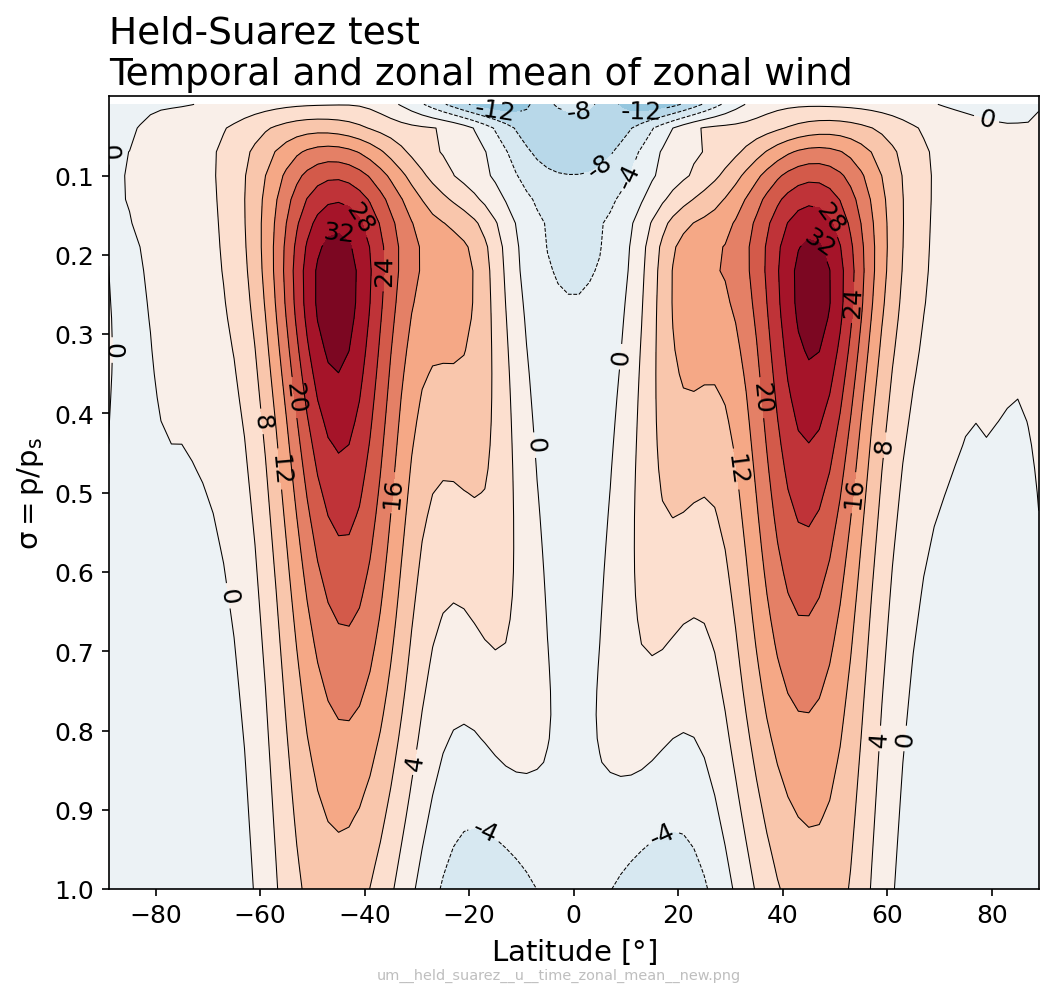

In [34]:
fig, ax = plt.subplots(figsize=(8, 7))

p0 = ax.contourf(
    lats,
    sigma_levels,
    u_tzm.data,
    cmap="RdBu_r",
    levels=np.arange(-36, 37, 4),
)
p1 = ax.contour(
    lats,
    sigma_levels,
    u_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(-100, 100, 4),
)
c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)

ax.set_xticks(np.arange(-80, 81, 20))
ax.set_yticks(np.arange(1.0, 0.0, -0.1))
ax.set_ylim([1, 0])

ax.set_xlabel("Latitude [$\degree$]")
ax.set_ylabel("$\sigma=p/p_s$")
ax.set_title("Held-Suarez test\nTemporal and zonal mean of zonal wind", loc="left")

imgname = plot_dir / "um__held_suarez__u__time_zonal_mean__new.png"
figsave(fig, imgname)

**Figure 14 and 16.** Horizontal cross-sections (maps)

Prepare the data

In [35]:
airtemp_1200d = extract_last_n_days(airtemp, 1)
# another way:
# airtemp_1200d = airtemp.extract(iris.Constraint(**{um.fcst_prd: 29_040}))
# or
# airtemp_1200d = airtemp[-1, ...]
# or
# from aeolus.coord import isel
# airtemp_1200d = isel(airtemp, um.t, -1)

Tip: `iris.Constraint(**{um.pres: 97000})` is equivalent to `iris.Constraint(air_pressure=97000)`

In [36]:
airtemp_1200d_single_lev = airtemp_1200d.extract(iris.Constraint(**{um.pres: 97000}))

In [37]:
u_tm = time_mean(
    pres_lev_cubes.extract_cube(um.u).extract(
        iris.Constraint(**{um.pres: lambda x: x in [97000, 53000, 22000]})
    )
)

v_tm = time_mean(
    pres_lev_cubes.extract_cube(um.v).extract(
        iris.Constraint(**{um.pres: lambda x: x in [97000, 53000, 22000]})
    )
)

In [38]:
u_tm.coord(um.pres)

DimCoord(array([97000., 53000., 22000.]), standard_name='air_pressure', units=Unit('Pa'))

##### Temperature: an old-school version for direct comparison with the paper

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__1200d_sigma0p97.png.png


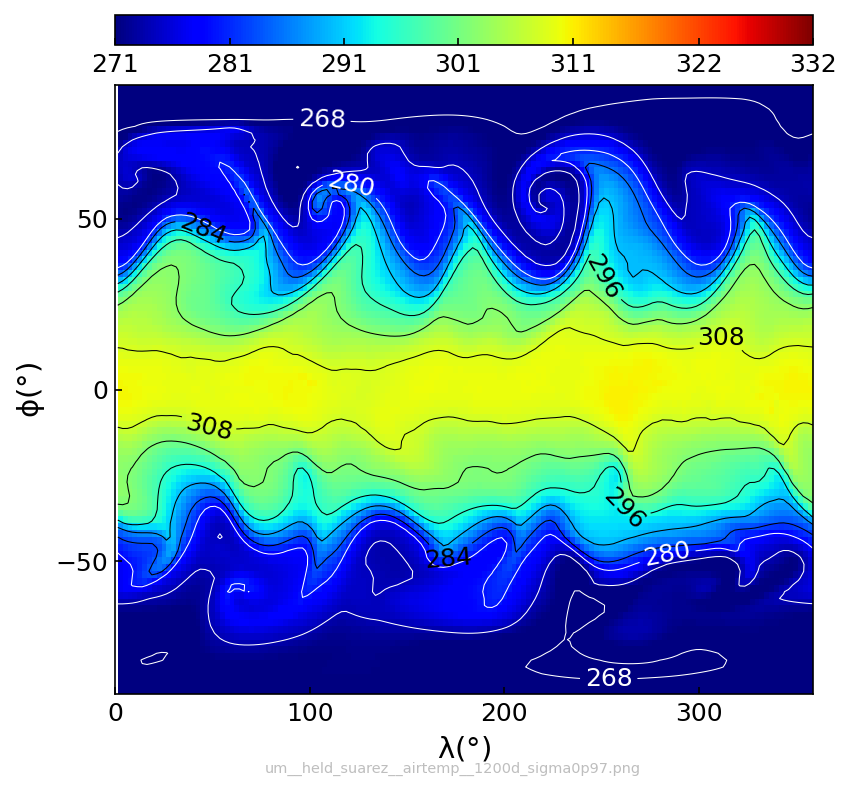

In [39]:
fig, (cax, ax) = plt.subplots(
    nrows=2,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [0.05, 1], "hspace": 0.125},
)

p0 = ax.pcolormesh(
    lons, lats, airtemp_1200d_single_lev.data, cmap="jet", vmin=271, vmax=332
)
p1 = ax.contour(
    lons,
    lats,
    airtemp_1200d_single_lev.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(284, 400, 6),
)
c1 = ax.clabel(p1, levels=np.arange(284, 400, 12), fmt="%.0f", use_clabeltext=True)
p2 = ax.contour(
    lons,
    lats,
    airtemp_1200d_single_lev.data,
    colors="w",
    linewidths=0.5,
    levels=np.arange(100, 284, 6),
)
c2 = ax.clabel(p2, levels=np.arange(100, 284, 12), fmt="%.0f", use_clabeltext=True)
ax.tick_params(direction="in")
ax.set_xticks(np.arange(0, 360, 100))
ax.set_yticks(np.arange(-50, 51, 50))

cb = fig.colorbar(p0, orientation="horizontal", cax=cax)
cb.ax.tick_params(direction="in")
cb.set_ticks([271, 281, 291, 301, 311, 322, 332])

ax.set_xlabel("$\lambda$($\degree$)")
ax.set_ylabel("$\phi$($\degree$)")

imgname = plot_dir / "um__held_suarez__airtemp__1200d_sigma0p97.png"
figsave(fig, imgname)

##### Winds

In [40]:
# your code here (adapt the code cell below)

##### Better versions

And now using a function to streamline the process.

In [41]:
def horiz_cross(var_key, save=True, add_minmax=True, figsize=(9, 4.5), model=um):
    """Make a plot of a horizontal cross-section for a given cube."""
    fig, ax = plt.subplots(figsize=figsize)

    vrbl = VAR_PLOT_DICT[var_key]["cube"]
    lons, lats = vrbl.coord(model.x).points, vrbl.coord(model.y).points

    p0 = ax.contourf(lons, lats, vrbl.data, **VAR_PLOT_DICT[var_key]["kw_plt_cf"])
    p1 = ax.contour(lons, lats, vrbl.data, **VAR_PLOT_DICT[var_key]["kw_plt_c"])
    plt.setp(p1.collections, path_effects=PE)
    c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
    plt.setp(c1, path_effects=PE)

    ax.set_xticks(np.arange(0, 361, 60))
    ax.set_yticks(np.arange(-90, 91, 30))

    ax.set_xlabel("Longitude [$\degree$]")
    ax.set_ylabel("Latitude [$\degree$]")
    ax.set_title(VAR_PLOT_DICT[var_key]["title"], loc="left")

    if add_minmax:
        at = AnchoredText(
            cube_stats_string(vrbl, sep="\n", fmt=".2f"), loc="upper left"
        )
        ax.add_artist(at)

    if save:
        imgname = plot_dir / f"um__held_suarez__{var_key}__new.png"
        figsave(fig, imgname)

Store all the plot settings in a dictionary, which will be used in the function above.

In [42]:
VAR_PLOT_DICT = {
    "airtemp__1200d_sigma0p97": {
        "title": f"{SIM_LABEL}\nAir temperature at 1200 days at $\sigma=0.970$",
        "cube": airtemp_1200d_single_lev,
        "kw_plt_cf": {
            "cmap": "plasma",
            "levels": np.arange(260, 320, 6),
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(200, 400, 6),
        },
    },
    "u_tm_sigma0p97": {
        "title": f"{SIM_LABEL}\nTime mean of zonal wind at $\sigma=0.970$",
        "cube": u_tm.extract(iris.Constraint(**{um.pres: 97000})),
        "kw_plt_cf": {
            "cmap": "RdBu_r",
            "levels": np.arange(-20, 21, 5),
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(-100, 100, 5),
        },
    },
    "u_tm_sigma0p53": {
        "title": f"{SIM_LABEL}\nTime mean of zonal wind at $\sigma=0.530$",
        "cube": u_tm.extract(iris.Constraint(**{um.pres: 53000})),
        "kw_plt_cf": {
            "cmap": "RdBu_r",
            "levels": np.arange(-20, 21, 5),  # ADJUST
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(-100, 100, 5),  # ADJUST
        },
    },
    # "u_tm_sigma0p23": {}  # CONTINUE
    "v_tm_sigma0p97": {
        "title": f"{SIM_LABEL}\nTime mean of meridional wind at $\sigma=0.970$",
        "cube": v_tm.extract(iris.Constraint(**{um.pres: 97000})),
        "kw_plt_cf": {
            "cmap": "RdBu_r",
            "levels": np.arange(-15, 16, 5),  # ADJUST
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(-100, 100, 5),  # ADJUST
        },
    },
    # "v_tm_sigma0p53": {}  # CONTINUE
}

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__1200d_sigma0p97__new.png.png


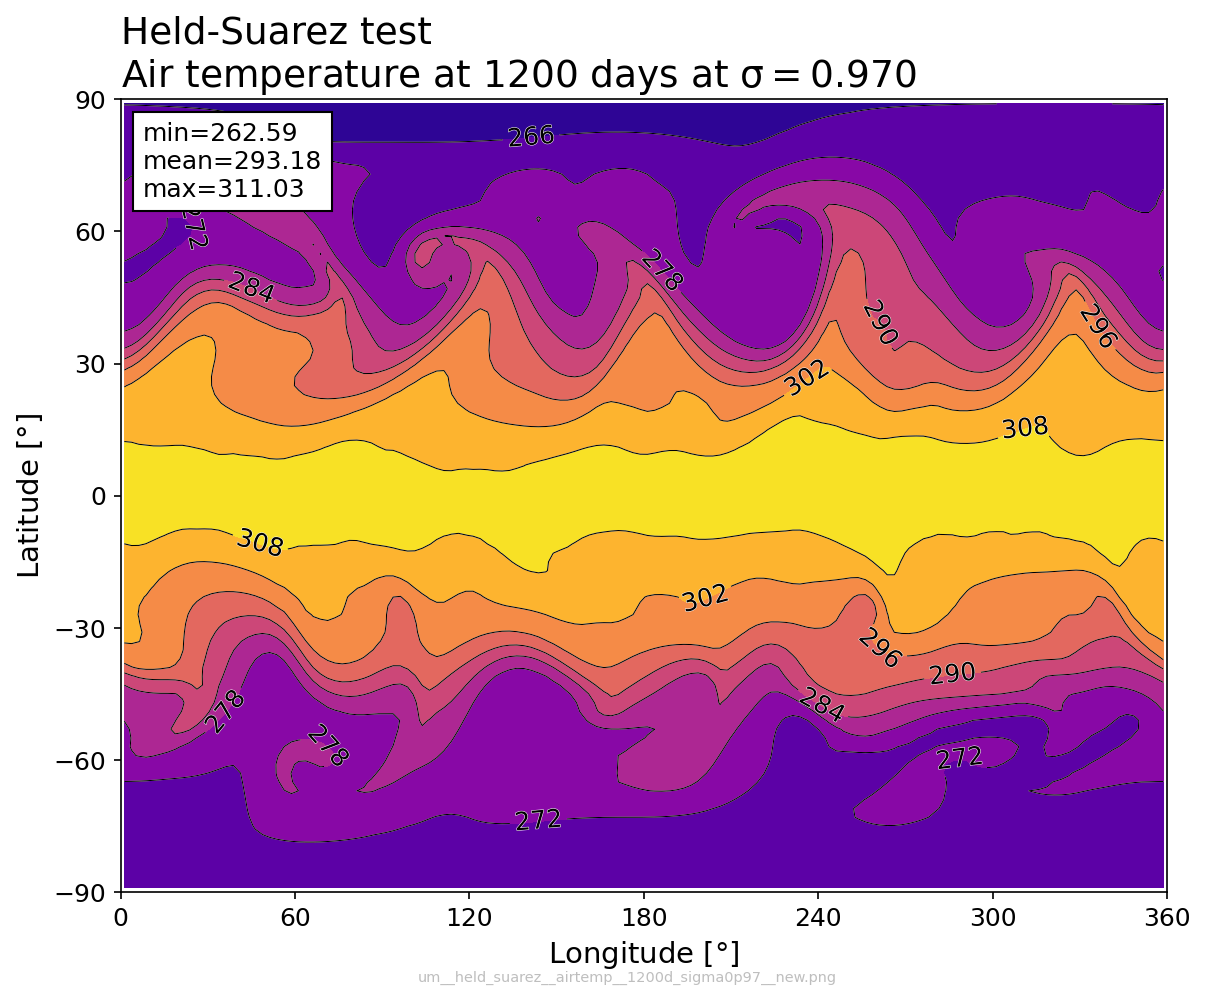

In [43]:
horiz_cross("airtemp__1200d_sigma0p97", figsize=(9, 7), save=True, add_minmax=True)

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__u_tm_sigma0p97__new.png.png


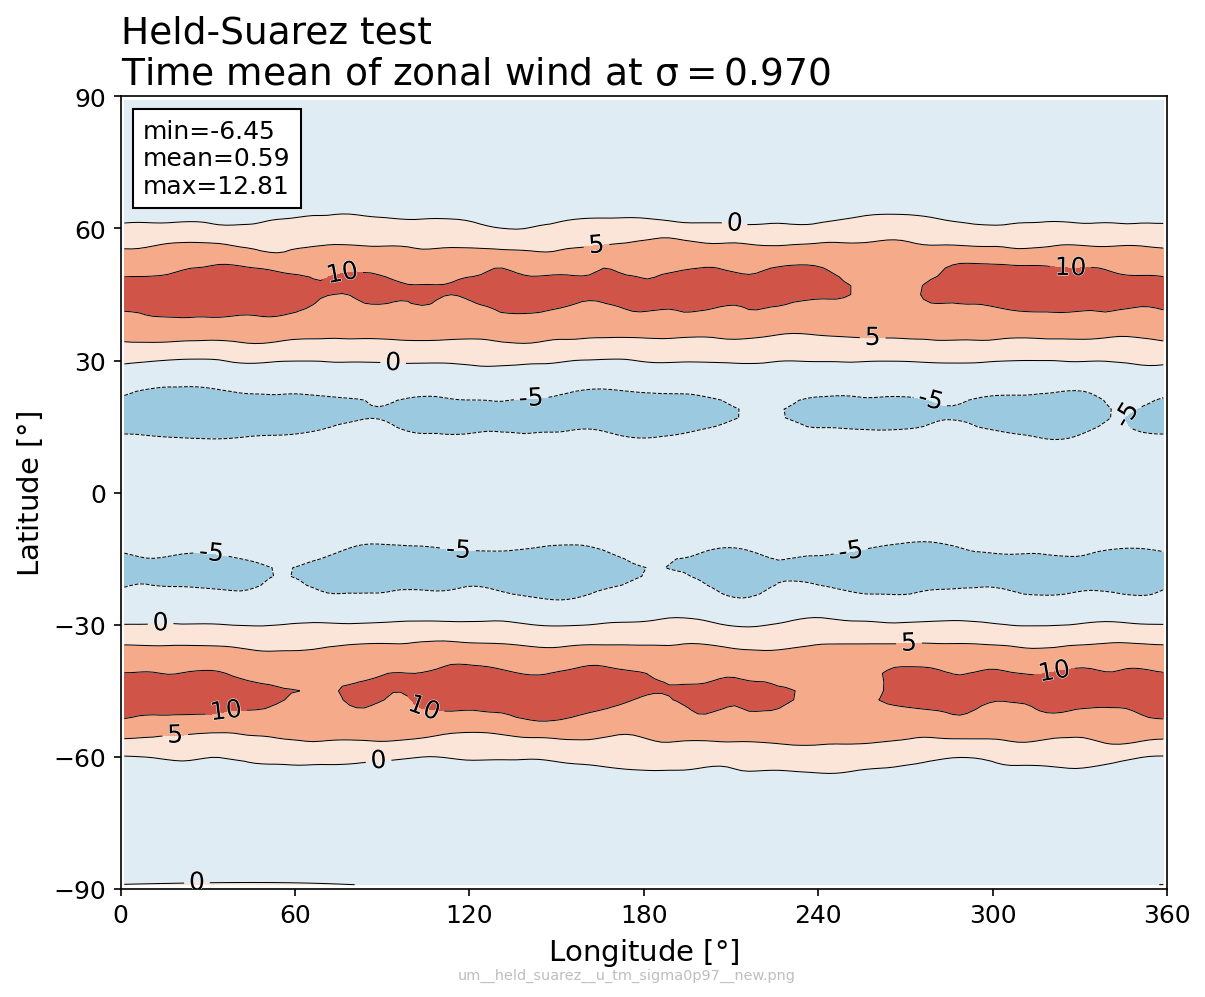

In [44]:
horiz_cross("u_tm_sigma0p97", figsize=(9, 7), save=True, add_minmax=True)

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__v_tm_sigma0p97__new.png.png


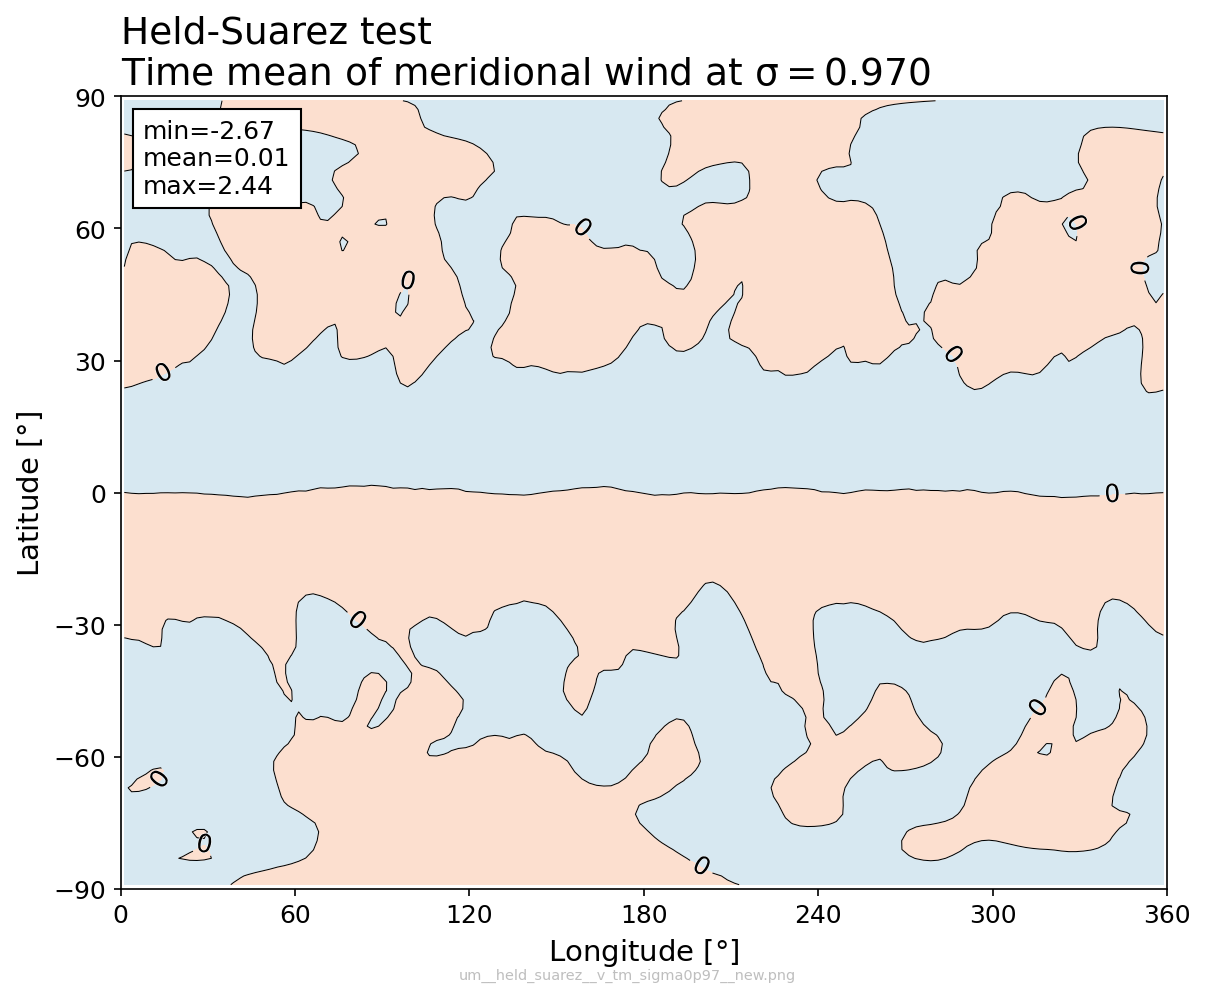

In [45]:
horiz_cross("v_tm_sigma0p97", figsize=(9, 7), save=True, add_minmax=True)